# Preparation

In [1]:
my_packages <- c("data.table", "tidyverse",
                 "patchwork", "ggforce", "ggpubr",
                 "survival", "survminer",
                 "Seurat")
pacman::p_load(char = my_packages)

tmp <- list()

In [2]:
sessionInfo()
# BY mugpeng@foxmail.com

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /data1/bioteam_usr/yzpeng/miniconda3/envs/R4.1/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=zh_CN.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=zh_CN.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=zh_CN.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] sp_1.5-0           SeuratObject_4.1.2 Seurat_4.2.0       patchwork_1.1.2   
 [5] lubridate_1.9.2    forcats_1.0.0      stringr_1.5.0      dplyr_1.1.2       
 [9] purrr_1.0.1        readr_2.1.4        tidyr_1.3.0        tibble_3.2.1      
[13] ggplot2_3.4.2      tidyverse_2.0.0    data.ta

# Error

Error: cannot find file files/17098533pa11001@student.must.edu.mo/results/CIBERSORTx_Job53_fibro_exp_ciber_inferred_phenoclasses.CIBERSORTx_Job53_fibro_exp_ciber_inferred_refsample.bm.K999.txt

It seems that only one sc ref file is allowed to generate, old file should be deleted if new need.
And It's better to on the running page of ref mtx generation.

# Data preprocess

## Seurat

In [16]:
seu_list <- readRDS(file = "Input/scRNAseqData of HCC/WholeTissueList.rds.gz")
seu <- merge(seu_list[[1]],y = seu_list[-1])

In [22]:
seu_mye <- seu_list$Myeloid

## TCGA

all:

In [ ]:
tcga_exp_raw <- as.data.frame(fread("Input/Bulk/TCGA-LIHC.htseq_fpkm.tsv.gz"))
geneprobe <- fread("Input/gencode.v22.annotation.gene.probeMap")
geneprobe <- unique(geneprobe[,1:2])
geneprobe <- geneprobe[match(tcga_exp_raw$Ensembl_ID, geneprobe$id),]
tcga_exp_raw$gene <- geneprobe$gene
tcga_exp_raw$Ensembl_ID <- NULL
tcga_exp <- aggregate(.~gene,
                      mean,
                      data = tcga_exp_raw)
tcga_exp <- as.data.frame(tcga_exp[!is.na(tcga_exp$gene),])
rownames(tcga_exp) <- tcga_exp$gene; tcga_exp$gene <- NULL
rm(tcga_exp_raw)

tmp$tumor_sample <- as.numeric(substr(colnames(tcga_exp), 14, 15))

# tumor and normal
tcga_exp_all <- tcga_exp
tcga_clinical_all <- data.frame(
  Sample = colnames(tcga_exp_all),
  Type = ifelse(tmp$tumor_sample < 10, "T", "N")
)

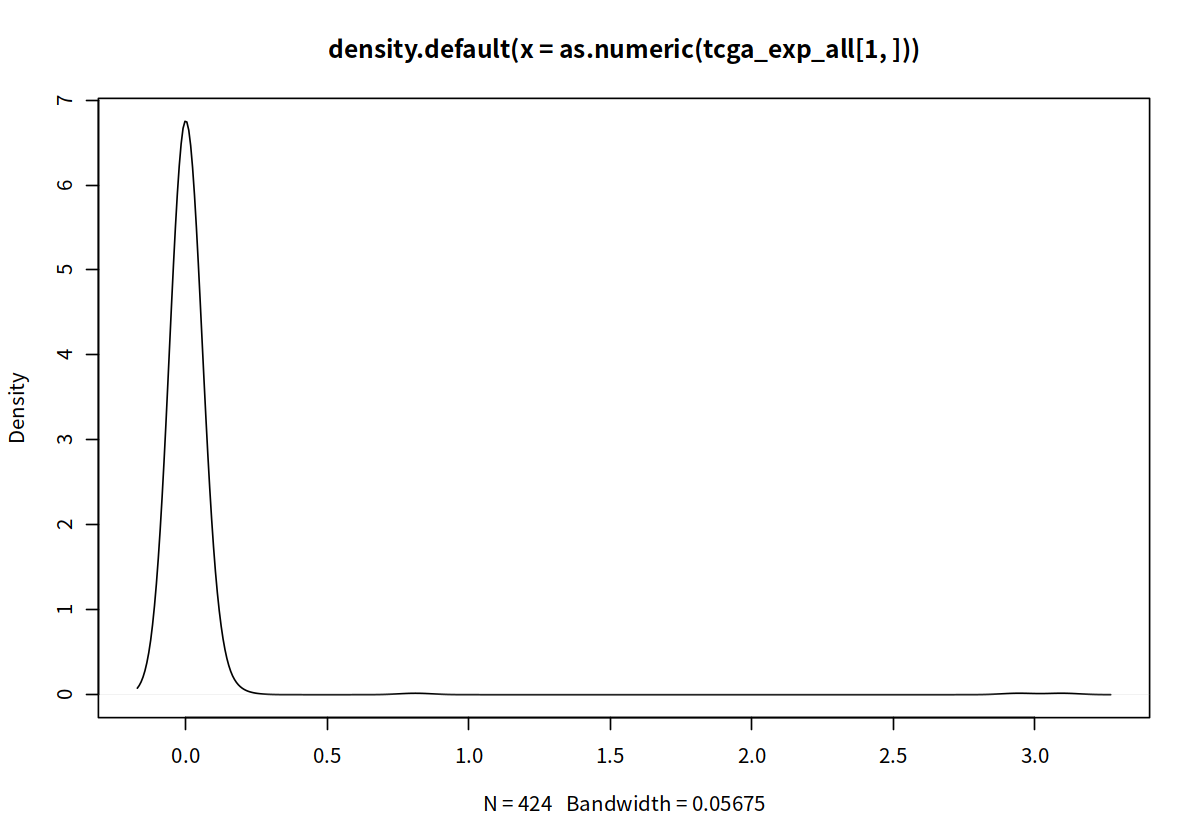

In [16]:
plot(density(as.numeric(tcga_exp_all[1,])))

only tumor:

In [ ]:
# Filter tumor-only tcga data:
tcga_exp <- tcga_exp[,tmp$tumor_sample < 10]
colnames(tcga_exp) <- substr(colnames(tcga_exp), 1, 12)

tcga_clinical <- fread("Input/Bulk/TCGA-LIHC.survival.tsv")
tcga_clinical <- unique(tcga_clinical[,-1])
colnames(tcga_clinical)[2] <- "Patient"

# tcga_clinical_all <- fread("Input/Bulk/TCGA-LIHC.GDC_phenotype.tsv.gz")
tcga_clinical_all <- fread("Input/Bulk/Survival_SupplementalTable_S1_20171025_xena_sp.txt")
tcga_clinical_all <- tcga_clinical_all[,c("_PATIENT",
                                     "PFI","PFI.time")]
tcga_clinical_all$Patient <- tcga_clinical_all$`_PATIENT`
tcga_clinical_all$`_PATIENT` <- NULL
tcga_clinical_all <- tcga_clinical_all[match(tcga_clinical$Patient, tcga_clinical_all$Patient),]

# merge PFI/PFS
tcga_clinical$PFS <- tcga_clinical_all$PFI
tcga_clinical$PFS.time <- tcga_clinical_all$PFI.time

tmp$intersected_patients <- intersect(tcga_clinical$Patient,
                                      colnames(tcga_exp))
# tcga_exp2 <- tcga_exp
tcga_exp <- tcga_exp[,match(tmp$intersected_patients, colnames(tcga_exp))]
tcga_clinical <- tcga_clinical[match(tmp$intersected_patients,
                                     tcga_clinical$Patient),]

## ICGC

all:

In [ ]:
icgc_exp_raw <- as.data.frame(fread("Input/Bulk/exp_seq.LIRI-JP.tsv.gz"))
icgc_exp_raw$specimen_type <- substr(icgc_exp_raw$submitted_sample_id,
                                     7, 12)
icgc_exp_raw$icgc_donor_id2 <- paste0(icgc_exp_raw$icgc_donor_id, "_", icgc_exp_raw$specimen_type)
icgc_exp_all <- dcast(data.table(icgc_exp_raw), gene_id~icgc_donor_id2,
                 value.var="raw_read_count", fun.aggregate = mean)
icgc_exp_all <- as.data.frame(icgc_exp_all); rownames(icgc_exp_all) <- icgc_exp_all$gene_id; icgc_exp_all$gene_id <- NULL
icgc_exp_all <- log2(icgc_exp_all + 1)
# rm na
icgc_exp_all <- as.matrix(icgc_exp_all)
icgc_exp_all[is.na(icgc_exp_all)] <- 0
icgc_exp_all <- as.data.frame(icgc_exp_all)

icgc_clinical_all <- data.frame(
  Sample = colnames(icgc_exp_all),
  Type = ifelse(grepl("Cancer", colnames(icgc_exp_all)), "T", "N")
)

only tumor:

In [ ]:
# only tumor
icgc_exp_raw_tumor <- icgc_exp_raw[icgc_exp_raw$specimen_type %in% "Cancer",]
icgc_exp <- dcast(data.table(icgc_exp_raw_tumor), gene_id~icgc_donor_id,
                 value.var="raw_read_count", fun.aggregate = mean)
icgc_exp <- as.data.frame(icgc_exp); rownames(icgc_exp) <- icgc_exp$gene_id; icgc_exp$gene_id <- NULL
icgc_exp <- log2(icgc_exp + 1)
# rm na
icgc_exp <- as.matrix(icgc_exp)
icgc_exp[is.na(icgc_exp)] <- 0
icgc_exp <- as.data.frame(icgc_exp)

icgc_clinical_raw <- fread("Input/Bulk/donor.LIRI-JP.tsv.gz")
icgc_clinical <- icgc_clinical_raw[!icgc_clinical_raw$donor_vital_status %in% "", c("icgc_donor_id",
                                                                                    "donor_vital_status",
                                                                            "donor_survival_time")]
icgc_clinical <- icgc_clinical[icgc_clinical$icgc_donor_id %in% colnames(icgc_exp),]
icgc_clinical <- icgc_clinical[match(colnames(icgc_exp), icgc_clinical$icgc_donor_id),]
icgc_clinical$OS <- ifelse(icgc_clinical$donor_vital_status == "alive", 0, 1)
icgc_clinical$donor_vital_status <- NULL
colnames(icgc_clinical)[2] <- "OS.time"


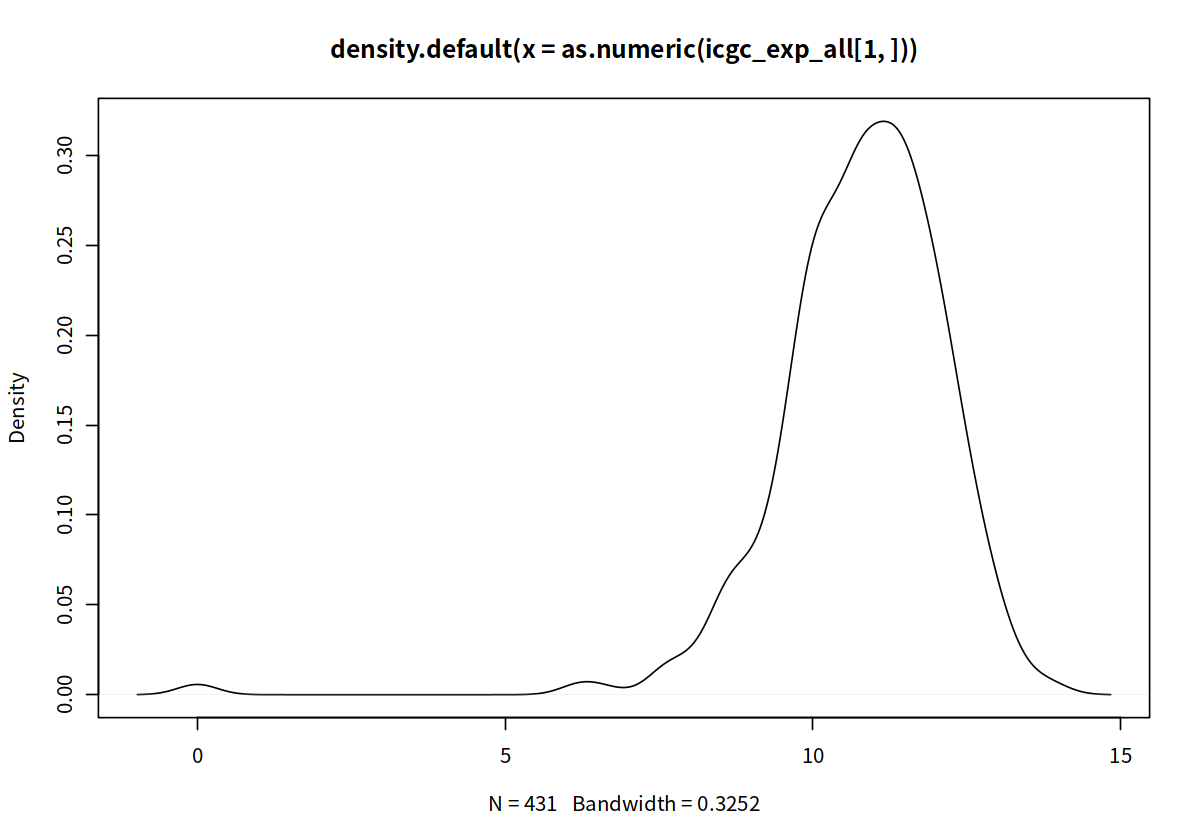

In [17]:
plot(density(as.numeric(icgc_exp_all[1,])))

# Fig3A

In [25]:
levels(seu_mye$DefineTypes)

[1] "Classical Monocyte"        "FOLR2 Macrophage"         
 [3] "Pro-inflammatory Monocyte" "Neutrophil"               
 [5] "CCL3L1 Macrophage"         "SPP1 Macrophage"          
 [7] "DC2"                       "Chemotactic Macrophage"   
 [9] "Mast cell"                 "Plasmacytoid DC"          
[11] "DC1"                       "Proliferating Macrophage"

In [26]:
seu_mye$Tissues2 <- plyr::mapvalues(seu_mye$Tissues, 
                                    from = c("N", "T"),
                                    to = c("Adjacent normal\n(n = 3,034)", "Tumour\n(n = 7,978)"))

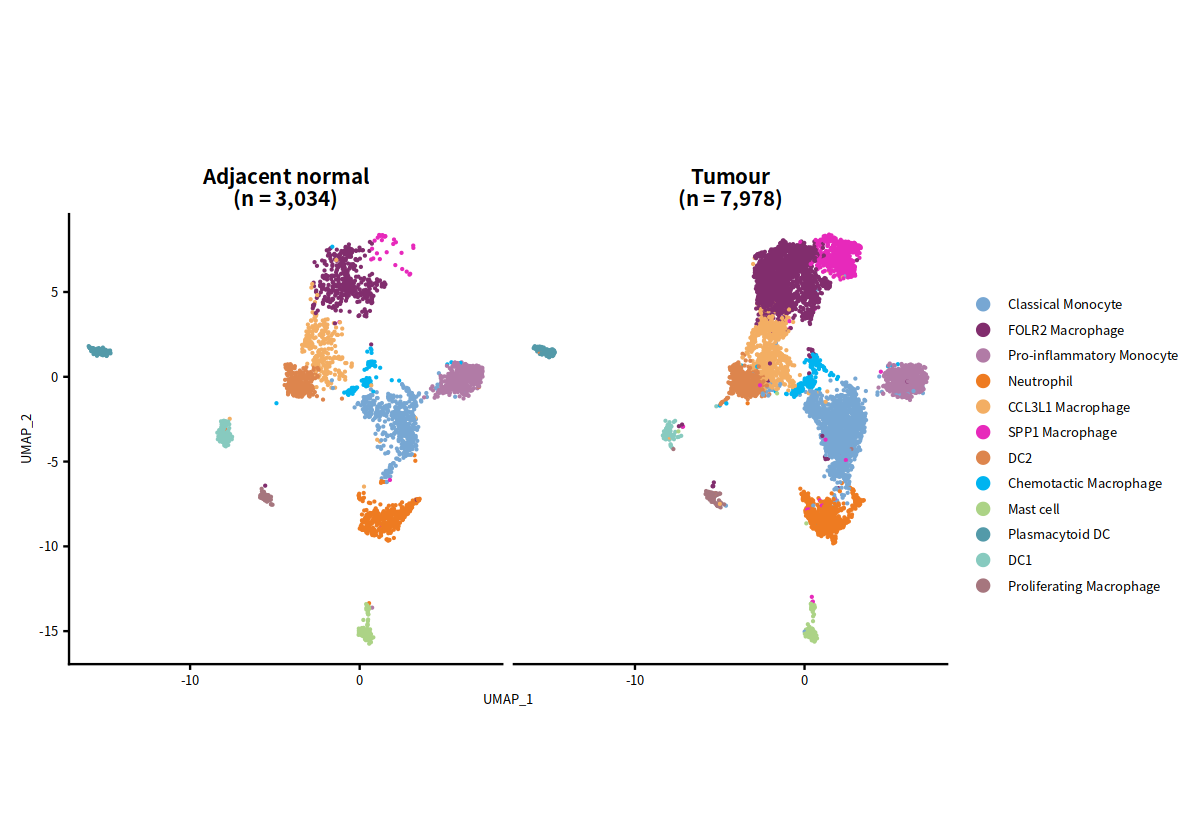

In [28]:
options(repr.plot.width=10, repr.plot.height=7)
pa <- DimPlot(seu_mye, reduction = "umap",
        group.by = "DefineTypes", split.by = "Tissues2") + scale_color_manual(values = c("#77a7d3","#812d6d","#b17ba6","#ee7b21","#f3ae63",
                                                                    "#e729bb","#dd854d","#00b4f0","#acd386","#539aa9","#87cabf","#a6767e")) +
    coord_fixed(ratio = 1) + 
    theme(panel.background = element_blank(),
          panel.grid.major=element_blank(),
          panel.grid.minor = element_blank(),
          plot.title = element_text(size = 9,
                                    hjust = 0.5),
          legend.text = element_text(size = 7.5),
          axis.title =  element_text(size = 7.5),
          axis.text = element_text(size = 7.5)) + 
    labs(title = "")
pa


The annotaiton effect of hull can be achieved by ggforce:
- [Accelerating ggplot2 • ggforce](https://ggforce.data-imaginist.com/)
- [Accelerate your plots with ggforce · R Views](https://rviews.rstudio.com/2019/09/19/intro-to-ggforce/)  

# Fig3B

In [29]:
seu_mye$Patient <- plyr::mapvalues(seu_mye$orig.ident, c("P11", "P15", "P12", "P2", "P21", "P22"), 
                                              c("P1", "P3", "P2", "P4", "P5", "P6"))
seu_mye$Samples <- paste0(seu_mye$Patient, seu_mye$Tissues)

In [32]:
spb_freq_df <- as.data.frame(prop.table(table(seu_mye$Samples, seu_mye$DefineTypes), margin = 2))
colnames(spb_freq_df) <- c("Samples", "major_celltype", "Freq")
head(spb_freq_df)

,Samples,major_celltype,Freq
,<fct>,<fct>,<dbl>
1,P1N,Classical Monocyte,0.07494253
2,P1T,Classical Monocyte,0.03126437
3,P2N,Classical Monocyte,0.07264368
4,P2T,Classical Monocyte,0.45241379
5,P3N,Classical Monocyte,0.06620690
6,P3T,Classical Monocyte,0.19678161


In [41]:
pal_b <- c("#A6CEE3","#1F78B4","#B2DF8A","#33A02C", 
           "#FB9A99","#E31A1C", "#FDBF6F", "#FF7F00",
           "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928")
prismatic::color(pal_b)

<colors>
#A6CEE3FF #1F78B4FF #B2DF8AFF #33A02CFF #FB9A99FF #E31A1CFF #FDBF6FFF #FF7F00FF #CAB2D6FF #6A3D9AFF #FFFF99FF #B15928FF 

Warning message:
“Duplicated aesthetics after name standardisation: colour”


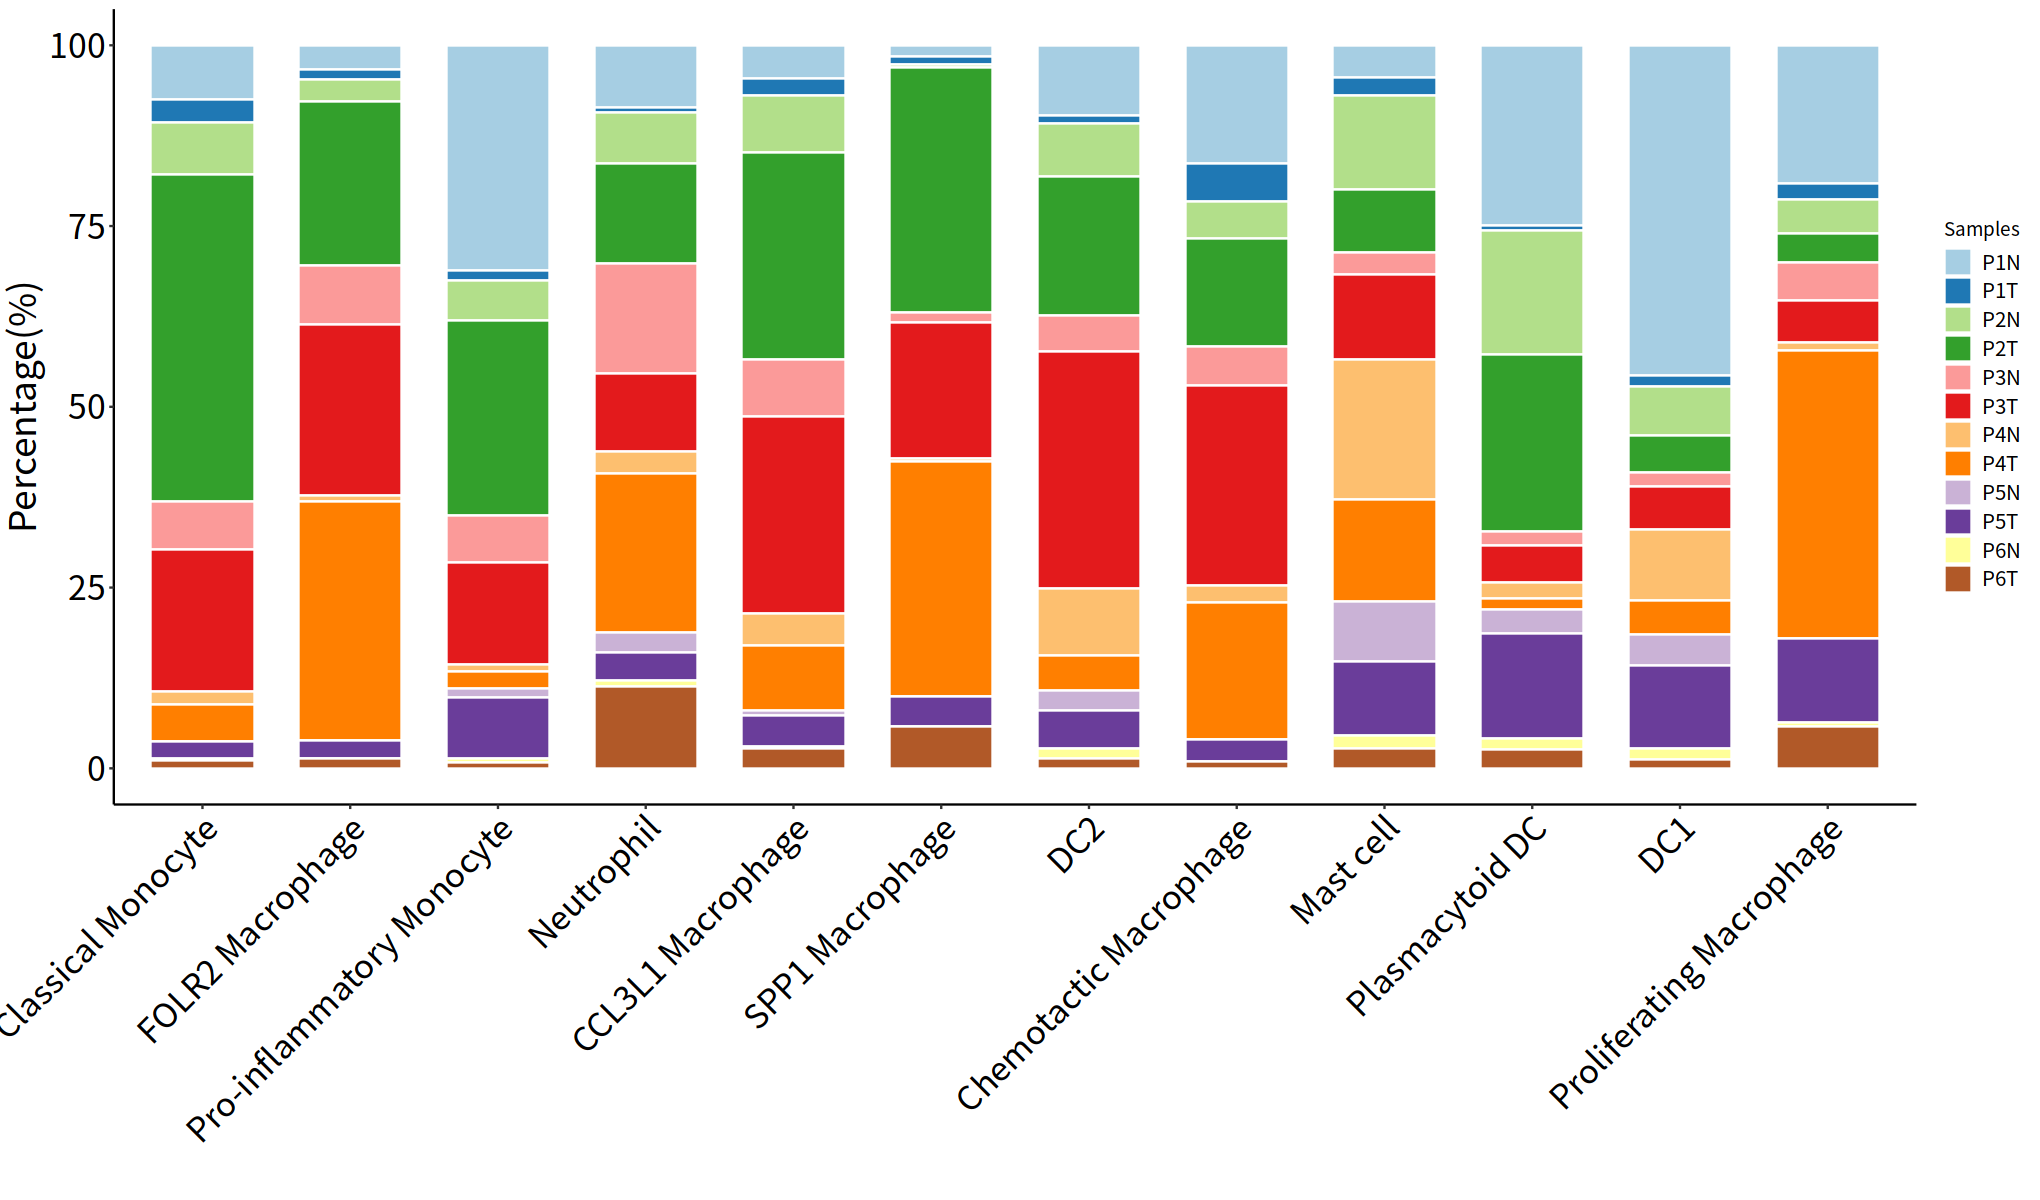

In [46]:
options(repr.plot.height=10, repr.plot.width=17)
pb <- ggplot(spb_freq_df) + 
  geom_bar(aes(x = major_celltype, y= Freq*100, fill = Samples),color = "white",stat = "identity",width = 0.7,size = 0.5,colour = '#222222')+ 
  theme_classic() +
  labs(x='',y = 'Percentage(%)')+
  scale_fill_manual(values = pal_b) +
  theme(axis.text = element_text(size=20,color = "black"),
        axis.text.x = element_text(angle = 45,hjust = 1),
        # axis.text.y= element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title = element_text(size=22),
        legend.text = element_text(size = 12))
pb

# Fig3C

## Prepare

In [4]:
seu_mye$Sample <- plyr::mapvalues(seu_mye$orig.ident, c("P11", "P15", "P12", "P2", "P21", "P22"), 
                                              c("P1", "P3", "P2", "P4", "P5", "P6"))

In [5]:
pal_c <- c("#66c2a5","#fc8d62","#8da0cb","#e78ac3","#a6d854","#ffd92f")
prismatic::color(pal_c)

<colors>
#66C2A5FF #FC8D62FF #8DA0CBFF #E78AC3FF #A6D854FF #FFD92FFF 

In [6]:
seu_mye_df <- as.data.frame(prop.table(table(seu_mye$Tissues, seu_mye$DefineTypes, seu_mye$Sample), margin = 3))
colnames(seu_mye_df) <- c("Tissue", "DefineTypes", "Patients", "Freq")
seu_mye_df2 <- seu_mye_df[seu_mye_df$DefineTypes %in% "SPP1 Macrophage",]

## Plot

Warning message in wilcox.test.default(c(0.910470409711684, 0.112170499158721, 0.370744860128076, :
“cannot compute exact p-value with ties”


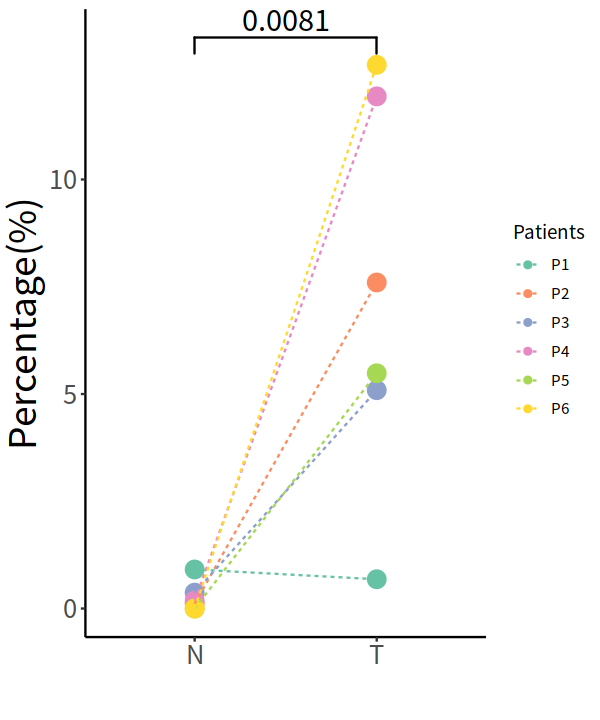

In [21]:
options(repr.plot.width=5, repr.plot.height=6)
pc <- ggplot(seu_mye_df2, aes(x = Tissue, y = Freq*100)) + 
geom_point(aes(color = Patients, size = 8)) + theme_classic() + 
guides(size = "none") + scale_color_manual(values = pal_c) + 
geom_line(aes(group = Patients, col = Patients), linetype=2) + 
geom_signif(comparisons = list(c("N", "T")),
              map_signif_level=F,
              textsize=6,test= "wilcox.test", step_increase=0.1) + 
              labs(x='',y = 'Percentage(%)') + 
              theme(
                axis.text = element_text(size = 15),
                axis.title = element_text(size=22)
              )
pc

# Fig3D,G

In [15]:
load("Tmpout/icgc_all.Rda")
load("Tmpout/tcga_all.Rda")

## Prepare for CibersortX

In [17]:
seu

An object of class Seurat 
27948 features across 83793 samples within 1 assay 
Active assay: RNA (27948 features, 0 variable features)

In [23]:
table(seu$DefineTypes)


               Bio potent                       CAF                 Capillary 
                      234                       290                       812 
           Capillary Vein         CCL3L1 Macrophage                   CD16 NK 
                       51                      1002                      4576 
                 CD160 NK                 CD8+ MAIT                  CD8+ Trm 
                    10858                      6123                      2562 
               CD99 BCell    Chemotactic Macrophage        Classical Monocyte 
                      391                       300                      2175 
        Cytotoxicity CD8T                       DC1                       DC2 
                     2593                       254                       774 
              DUSP2 BCell            Exhausted CD8T          Follicular BCell 
                      638                     10757                       879 
         FOLR2 Macrophage                GAS5 BCell

Input format is described at: [CIBERSORTx](https://cibersortx.stanford.edu/tutorial.php)

In [19]:
extractCiberInput1 <- function(seu){
  exp <- seu@assays$RNA@counts
  exp <- exp[rownames(exp) %in% VariableFeatures(seu),]
  exp <- as.matrix(exp); exp <- as.data.frame(exp)
  exp$Gene <- rownames(exp)
  exp <- exp[,c(ncol(exp),1:(ncol(exp)-1))]
  colnames(exp)[2:ncol(exp)] <- as.character(seu$DefineTypes)
  return(exp)
}

extractCiberInput2 <- function(df){
  df <- 2**(df) - 1
  df <- as.data.frame(df)
  df$Gene <- rownames(df)
  df <- df[,c(ncol(df),1:(ncol(df)-1))]
  return(df)
}

In [ ]:
# tcga
tcga_exp_ciber <- extractCiberInput2(tcga_exp_all)
fwrite(tcga_exp_ciber, "Tmpout/tcga_exp_ciber.txt", quote = F, row.names = F, col.names = T,
       sep = "\t")

# icgc
icgc_exp_ciber <- extractCiberInput2(icgc_exp_all)
fwrite(icgc_exp_ciber, "Tmpout/icgc_exp_ciber.txt", quote = F, row.names = F, col.names = T,
       sep = "\t")

The max storage is 1G for cibersortx website, thus we downsample the seurat obj.

In [20]:
# seurat subset
Idents(seu) <- "DefineTypes"
# Downsample the number of cells per identity class
seu2 <- subset(x = seu, downsample = 1000, seed = 1)
seu2 <- NormalizeData(seu2) %>% FindVariableFeatures(selection.method = "vst", nfeatures = 10000)
seu_exp <- extractCiberInput1(seu2)
fwrite(seu_exp, "Tmpout/seu_exp_ciber.txt", quote = F, row.names = F, col.names = T,
       sep = "\t")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


Build Ref mtx from single cell, then estimate proportion from TCGA and ICGC.

Ref: [CIBERSORTx](https://cibersortx.stanford.edu/tutorial.php)

Set parameters:
- Disable quantile normalization (disabling is recommended for RNA-Seq data)
- 500 Permutations

### Cibersortx

![](http://cos01.mugpeng.top/img/20231219112258.png)

## Load results

In [2]:
load("Tmpout/tcga_tumor.Rda")
load("Tmpout/tcga_all.Rda")
load("Tmpout/icgc_tumor.Rda")
load("Tmpout/icgc_all.Rda")

In [4]:
ciber_tcga_df_raw <- fread("Input/Cibersortx/tcga.txt")
ciber_tcga_df <- merge(ciber_tcga_df_raw[,c("Mixture", "SPP1 Macrophage", "CAF")], tcga_clinical_all, by.x = "Mixture", by.y = "Sample")

In [5]:
ciber_tcga_df_T <- ciber_tcga_df[ciber_tcga_df$Type %in% "T",]
ciber_tcga_df_T$Mixture <- substr(ciber_tcga_df_T$Mixture, 1, 12)
ciber_tcga_df_T <- ciber_tcga_df_T[match(tcga_clinical$Patient,ciber_tcga_df_T$Mixture),]

In [6]:
tcga_clinical$OS.time <- tcga_clinical$OS.time/30
fivenum(tcga_clinical$OS.time)

[1]   0.03333333  11.46666667  19.86666667  36.26666667 122.50000000

## D

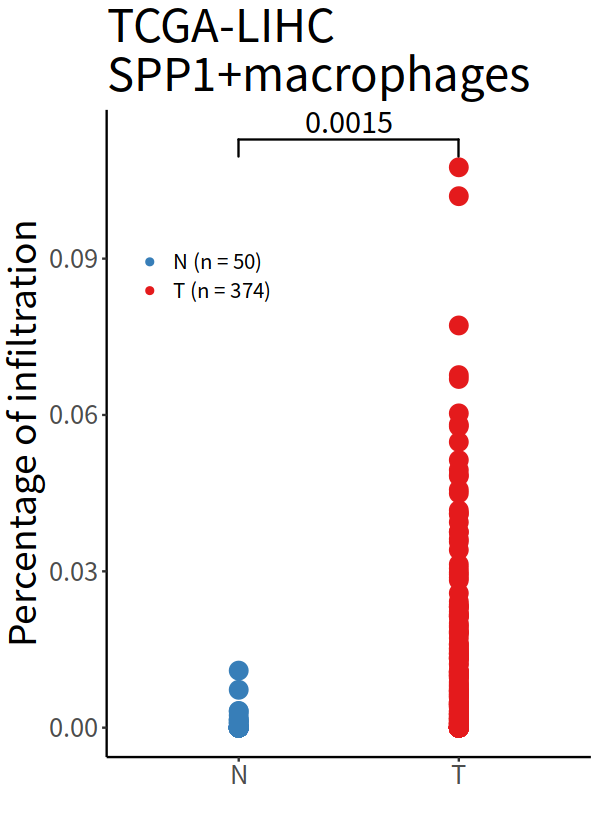

In [7]:
options(repr.plot.width=5, repr.plot.height=7)
ggplot(ciber_tcga_df, aes(x = Type, y = `SPP1 Macrophage`)) + geom_point(aes(color = Type, size = 5)) + 
    theme_classic() + guides(size = "none") + 
    scale_color_manual(values = c("#377EB8", "#E41A1C"),
                       labels = c("N (n = 50)","T (n = 374)")) + 
    geom_signif(comparisons = list(c("N", "T")),
                map_signif_level=F,
                textsize=6,test= "wilcox.test", step_increase=0.1) + labs(x = "", y = "Percentage of infiltration") + theme(
                  legend.title = element_blank(),
                  legend.position = c(.2, .75),
                  legend.text = element_text(size = 12),
                  axis.text = element_text(size = 15),
                  axis.title = element_text(size = 22),
                  plot.title = element_text(size = 27)
                  ) + ggtitle("TCGA-LIHC \nSPP1+macrophages")

## G

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


$SPP1_Macrophage


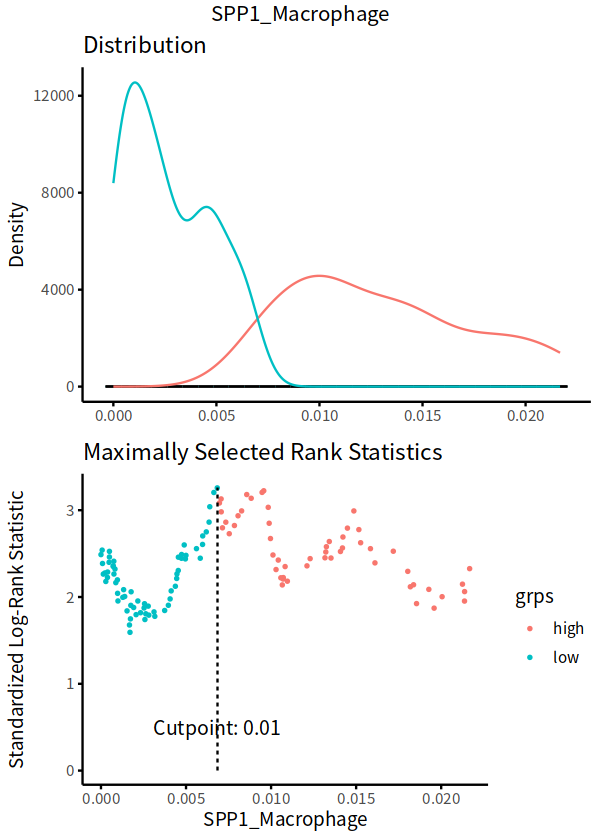

In [9]:
tcga_clinical$SPP1_Macrophage <- ciber_tcga_df_T$`SPP1 Macrophage`


res.cut <- surv_cutpoint(tcga_clinical, time = "OS.time", event = "OS",
                         variables = "SPP1_Macrophage")
plot(res.cut, "SPP1_Macrophage")

In [10]:
tcga_clinical$SPP1_group <- ifelse(
  tcga_clinical$SPP1_Macrophage > res.cut$cutpoint$cutpoint, "high", "low"
)

In [11]:
sfit <- survfit(Surv(OS.time, OS)~SPP1_group, data=tcga_clinical)
p <- ggsurvplot(sfit, conf.int=F, pval=TRUE, 
                     risk.table = T,
                pval.size = 6,
          palette = c('#FF2800', "#0000FF"),
           ggtheme = theme_classic(),
          legend.labs = c("high risk (n = 74)","low risk (n = 291)"))

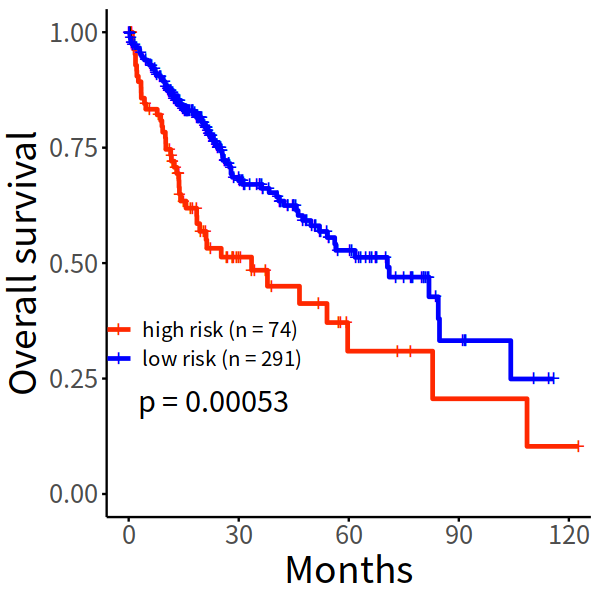

In [12]:
options(repr.plot.width=5, repr.plot.height=5)
pg <- p$plot + labs(x = "Months", y = "Overall survival") + theme(
  axis.text = element_text(size = 15),
  axis.title = element_text(size = 22),
  legend.position = c(.2, .35),
  legend.text = element_text(size = 12),
  legend.title = element_blank(),
  legend.background = element_rect(fill = "transparent")
)
pg

# Save

In [ ]:
# all
save(icgc_exp,
     icgc_clinical,
     file = "Tmpout/icgc_tumor.Rda")

save(icgc_exp_all,
     icgc_clinical_all,
     file = "Tmpout/icgc_all.Rda")

# tumor
save(icgc_exp,
     icgc_clinical,
     file = "Tmpout/icgc_tumor.Rda")

save(tcga_exp,
     tcga_clinical,
     file = "Tmpout/tcga_tumor.Rda")